# Exact GP Regression Tutorial
## Introduction
In this notebook, we use DMGP to train a simplest regression model. We'll be modeling the function
\begin{align}
&y = \sin(2\pi x) + \epsilon, \\
&\epsilon \sim \mathcal{N}(0,0.04).
\end{align}
with 100 trianing examples, and testing on 4 test examples.

**Note:** this notebook is not necessarily intended to teach the mathematical background of Gaussian processes, but rather how to train a simple one and make predictions in DMGP. For a mathematical treatment, please see the reference "A sparse expansion for deep Gaussian processes": https://arxiv.org/abs/2112.05888

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dmgp.models import DMGP
from dmgp.layers.activation import TMK, AMK
from dmgp.layers.linear import LinearFlipout

### Set up training data
In the next cell, we set up the training data for this example. We’ll be using 100 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

class RegressionDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset = RegressionDataset(train_x, train_y)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True)

## Setting up the model
The next cell demonstrates the most critical features of a user-defined DGP model in DMGP. Basically, there are two ways to define a customized DGP model: use `dmgp.models.DMGP` or construct your model from scratch using `dmgp.layers`.

If we define the model using `dmgp.models.DMGP`, you need to construct the following DMGP objects:
1. Input and output dimension (`input_dim`, `output_dim`) - For regression `output_dim=1`.
2. Number of hidden layers (`num_layers`) - Usually we use 2 hidden layers.
3. Level of inducing (`num_inducing`) - This sets the level of inducing points we use for GP inference.
4. Dimension of hidden layers (`hidden_dim`) - This sets the width of hidden layers.
5. A kernel (`kernel`) - This defines the prior covariance of the GP. (In DMGP, `DMGP.kernels.laplace_kernel.LaplaceProductKernel` is a good choice to start).
6. A layer type (`layer_type`) - This defines the linear Bayesian layer we use for learnable GP weights. (`DMGP.layers.linear.LinearFlipout` is used by default).

In [3]:
from dmgp.utils.sparse_design.design_class import HyperbolicCrossDesign
from dmgp.kernels.laplace_kernel import LaplaceProductKernel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using: ", device)

# Define the model using DMGP
model = DMGP(input_dim=1,
             output_dim=1,
             num_layers=2,
             hidden_dim=8,
             num_inducing=3,
             input_lb=0,
             input_ub=1,
             kernel=LaplaceProductKernel(1.),
             design_class=HyperbolicCrossDesign,
             layer_type=LinearFlipout,
             option='additive').to(device)

Using:  cpu


If we define the customized model from scratch, the following is an example which consists of two GP layers, each with level-8 and level-3 sparse grid design, respectively.

In [4]:
# Define a DMGP model from scratch
class DMGP_regression(nn.Module):
    def __init__(self, input_dim, output_dim, design_class, kernel):
        super(DMGP_regression, self).__init__()
        
        # 1st layer of DGP: input:[n, input_dim] size tensor, output:[n, 8] size tensor
        self.mk1 = AMK(in_features=input_dim, n_level=8, input_lb=0, input_ub=1, design_class=design_class, kernel=kernel)
        self.fc1 = LinearFlipout(self.mk1.out_features, 16)

        # 2nd layer of DGP: input:[n, 8] size tensor, output:[n, output_dim] size tensor
        self.mk2 = AMK(in_features=16, n_level=3, input_lb=0, input_ub=1, design_class=design_class, kernel=kernel)
        self.fc2 = LinearFlipout(in_features=self.mk2.out_features, out_features=output_dim)

    def forward(self, x):
        kl_sum = 0
        x = self.mk1(x)
        x, kl = self.fc1(x)
        kl_sum += kl
        x = self.mk2(x)
        x, kl = self.fc2(x)
        kl_sum += kl
        return torch.squeeze(x), kl_sum
    
model = DMGP_regression(input_dim=1, output_dim=1, design_class=HyperbolicCrossDesign, kernel=LaplaceProductKernel(1.)).to(device)

## Training the model
In the next cell, we handle using variational inference (VI) to train the parameters of the DMGP.

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(200):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.unsqueeze(-1).to(device), target.to(device)
        optimizer.zero_grad()
        output_ = []
        kl_ = []
        for mc_run in range(5):
            output, kl = model(data)
            output_.append(output)
            kl_.append(kl)
        output = torch.mean(torch.stack(output_), dim=0)
        kl = torch.mean(torch.stack(kl_), dim=0)
        nll_loss = F.mse_loss(output, target)
        # ELBO loss
        loss = nll_loss + (kl / 20)
        loss.backward()
        optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

Epoch: 0, Loss: 1.1520733833312988
Epoch: 20, Loss: 0.36286112666130066
Epoch: 40, Loss: 0.29386594891548157
Epoch: 60, Loss: 0.24582257866859436
Epoch: 80, Loss: 0.18998956680297852
Epoch: 100, Loss: 0.2428296059370041
Epoch: 120, Loss: 0.17667627334594727
Epoch: 140, Loss: 0.20650288462638855
Epoch: 160, Loss: 0.17948392033576965
Epoch: 180, Loss: 0.15232783555984497


## Making predictions with the model
In the next cell, we make predictions with the model. To do this, we simply put the model in eval mode, and call both modules on the test data.

In [6]:
# Test points are regularly spaced along [0,1]
test_x = torch.linspace(0, 1, 4)
test_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

test_set = RegressionDataset(test_x, test_y)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=50, shuffle=True)

# Make predictions by feeding test dat through DMGP model
test_loss = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.unsqueeze(-1).to(device), target.to(device)
        predicts = []
        for mc_run in range(20):
            model.eval()
            output, _ = model.forward(data)
            loss = F.mse_loss(output, target).cpu().data.numpy()
            test_loss.append(loss)
            predicts.append(output.cpu().data.numpy())

        pred_mean = np.mean(predicts, axis=0)
        pred_std = np.std(predicts, axis=0)
        
print('test loss: ', np.mean(test_loss))

test loss:  0.81287956


## Plot the model fit
In the next cell, we plot the mean and confidence region of the DMGP prediction.

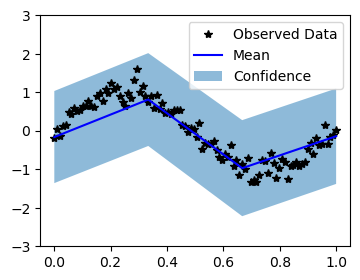

In [7]:
from matplotlib import pyplot as plt
from scipy import stats

# Confidence level
confidence_level = 0.95
z = stats.norm.ppf(1 - (1 - confidence_level) / 2)  # z-score for 95% confidence

# Calculate the confidence interval
lower = pred_mean - z * pred_std
upper = pred_mean + z * pred_std

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), pred_mean, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])